In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.datasets import load_diabetes
from sklearn import datasets
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pprint import pprint
import seaborn as sns
import pdb
sns.set_style(style="whitegrid")
from matplotlib import rcParams

%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.figsize'] = 16,8

Random Forest Regressor Source Code

In [3]:
class Node:
    def __init__(self, feature=None, threshold=None,left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None
    
class DecisionTreeRegressor:
    def __init__(self, subspace=256, n_features=None):
        self.n_features=n_features
        self.root=None
    
    def select_feature(self,data,feat_idxs): 
        '''
        Randomly select a feature of a dataframe
        '''
          # Exclude the last column
        
        return random.choice(feat_idxs)
    
    def select_value(self,data,feat):
        '''
        Select values of 
        '''
        mini = data.iloc[:, feat].min()  # Accessing column by index
        maxi = data.iloc[:, feat].max()
        return (maxi-mini)*np.random.random()+mini
        
    def fit(self,X):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root=self.grow_tree(X)
    
    def grow_tree(self,X):
        n_samples, n_feats = X.shape
        
        if(n_samples==0):
            return None
        
        if(n_samples<=1):
            classification=self.classify_data(X)
            return Node(value=classification)
        
        else:
            feat_idxs=list(np.random.choice(n_feats-1, self.n_features-1, replace=False))
            best_feature, best_thresh = self._best_split(X, feat_idxs)
            
            # create child nodes
            left_idxs, right_idxs = self._split(X.iloc[:, best_feature], best_thresh)
            left = self.grow_tree(X.loc[left_idxs])
            right = self.grow_tree(X.loc[right_idxs])
            return Node(best_feature, best_thresh, left, right)
        
    def _best_split(self, X, feat_idxs):
        # print("best_split function starts")
        best_var_red = -1
        split_idx = None
        split_threshold=None
        
        for feat_idx in feat_idxs:
            X_column = X.iloc[:, feat_idx]
            X_column_series = pd.Series(X_column)
            thresholds = np.array(X_column_series.unique())
            

            for thr in thresholds:
                # calculate the variance reduction
                curr_var_red = self.variance_reduction(X, X_column, thr)

                if curr_var_red > best_var_red:
                    best_var_red = curr_var_red
                    split_idx = feat_idx
                    split_threshold = thr
                    
        if best_var_red == 0:
            split_idx=self.select_feature(X,feat_idxs)
            split_threshold=self.select_value(X,split_idx)

        return split_idx, split_threshold 
    
    def variance_reduction(self, X, X_column, threshold):
        parent=X.iloc[:,-1]
        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        l_child=parent[left_idxs]
        r_child=parent[right_idxs]
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def _split(self, X_column, split_thresh):
        left_idxs = X_column.index[X_column <= split_thresh].tolist()
        right_idxs = X_column.index[X_column > split_thresh].tolist()
        return left_idxs, right_idxs
    
    def classify_data(self,data):
        label_column = data.values[:, -1]
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        index = counts_unique_classes.argmax()
        classification = unique_classes[index]
        return classification   

In [4]:
class RandomForestRegressor:
    def __init__(self,n_trees=10, subspace=256):
        self.n_trees=n_trees
        self.subspace=subspace
        self.forest = []
        self.depth=[]
        
    def fit(self,X):
        if self.subspace<=1:
            self.subspace=self.subspace*df.shape[0]
        
        for i in range(self.n_trees):
            # Sample the subspace
            if self.subspace<=1:
                X = X.sample(frac=self.subspace)
            else:
                X = X.sample(self.subspace)
                
            # Fit tree
            tree = DecisionTreeRegressor(subspace=self.subspace)
            tree.fit(X)
            
            if tree.root is not None:
                self.forest.append(tree)
            
    def _path_(self,x,node,path):
        if(node is None):
            return path
        path=path+1
        if node.is_leaf_node():
            return path
        if x.iloc[0, node.feature] <= float(node.threshold):
            return self._path_(x,node.left,path)
        elif x.iloc[0, node.feature] > float(node.threshold):
            return self._path_(x,node.right,path)
        return path
        
    def pathLength(self,example,iTree):
        return self._path_(example,iTree.root,path=0)
        
    def evaluate_instance(self,instance):
        paths = []
        for tree in self.forest:
            paths.append(self.pathLength(instance,tree))
        return paths 
    
    def c_factor(self) :
        return 2.0*(np.log(self.subspace-1)+0.5772156649) - (2.0*(self.subspace-1.)/(self.subspace*1.0))
    
    def anomaly_score(self,data_point):

        # Mean depth for an instance
        E = np.mean(self.evaluate_instance(data_point))

        c = self.c_factor()

        return 2**-(E/c)
    
    def decisionScore(self,X):
        decision_score= []
        for i in range(X.shape[0]):
            decision_score.append(self.anomaly_score(X.iloc[[i]]))
        return decision_score
    
    def predict(self,X,contamination):
        decision_score=self.decisionScore(X)
        prediction = []
        total_contamination = int(contamination * len(decision_score))
        anomaly_score = np.sort(np.array(decision_score))[::-1]
        anomaly_score = anomaly_score[:total_contamination]
        for score in decision_score:
            if score in anomaly_score:
                prediction.append(-1)
            else:
                prediction.append(1)
        return prediction


Random Forest Classifier Source Code

In [5]:
class Node:
    def __init__(self, feature=None, threshold=None,left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None
    
class DecisionTreeClassifier:
    def __init__(self, n_features=9):
        self.n_features=n_features
        self.root=None

    def select_feature(self,data,feat_idxs): 
        '''
        Randomly select a feature of a dataframe
        '''
          # Exclude the last column
        
        return random.choice(feat_idxs)
    
    def select_value(self,data,feat):
        '''
        Select values of 
        '''
        mini = data.iloc[:, feat].min()  # Accessing column by index
        maxi = data.iloc[:, feat].max()
        return (maxi-mini)*np.random.random()+mini

        
    def fit(self,X):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root=self.grow_tree(X)
    
    def grow_tree(self,X):
        n_samples, n_feats = X.shape
        
        if(n_samples==0):
            return None
        
        if(n_samples<=1):
            classification=self.classify_data(X)
            return Node(value=classification)
        
        else:
            feat_idxs=list(np.random.choice(n_feats-1, self.n_features-1, replace=False))
            best_feature, best_thresh = self._best_split(X, feat_idxs)
            left_idxs, right_idxs = self._split(X.iloc[:, best_feature], best_thresh)
            left = self.grow_tree(X.loc[left_idxs])
            right = self.grow_tree(X.loc[right_idxs])
            return Node(best_feature, best_thresh, left, right)
        
    def _best_split(self, X, feat_idxs):
        best_var_red = -1
        split_idx = None
        split_threshold=None
        
        for feat_idx in feat_idxs:
            X_column = X.iloc[:, feat_idx]
            X_column_series = pd.Series(X_column)
            thresholds = np.array(X_column_series.unique())
            

            for thr in thresholds:
                # calculate the variance reduction
                curr_var_red = self._information_gain(X, X_column, thr, "gini")
                if curr_var_red > best_var_red:
                    best_var_red = curr_var_red
                    split_idx = feat_idx
                    split_threshold = thr
                    
        if best_var_red == 0:
            split_idx=self.select_feature(X,feat_idxs)
            split_threshold=self.select_value(X,split_idx)
        return split_idx, split_threshold 
    
    def _information_gain(self, X, X_column, threshold, mode="entropy"):
        parent=X.iloc[:,-1]
        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        l_child=parent[left_idxs]
        r_child=parent[right_idxs]
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="entropy":
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
            return gain
        else:
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
            return gain
        
    def _entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
    
    def _split(self, X_column, split_thresh):
        left_idxs = X_column.index[X_column <= split_thresh].tolist()
        right_idxs = X_column.index[X_column > split_thresh].tolist()
        return left_idxs, right_idxs
    
    def classify_data(self,data):
        label_column = data.values[:, -1]
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        index = counts_unique_classes.argmax()
        classification = unique_classes[index]
        return classification   

In [6]:
class RandomForestClassifier:
    def __init__(self,n_trees=10, subspace=256):
        self.n_trees=n_trees
        self.subspace=subspace
        self.forest = []
        self.depth=[]
        
    def fit(self,X):
        if self.subspace<=1:
            self.subspace=self.subspace*df.shape[0]
        
        for i in range(self.n_trees):
            # Sample the subspace
            if self.subspace<=1:
                X = X.sample(frac=self.subspace)
            else:
                X = X.sample(self.subspace)
                
            # Fit tree
            tree = DecisionTreeClassifier()
            tree.fit(X)
            
            if tree.root is not None:
                self.forest.append(tree)
            
    def _path_(self,x,node,path):
        if(node is None):
            return path
        path=path+1
        if node.is_leaf_node():
            return path
        if x.iloc[0, node.feature] <= float(node.threshold):
            return self._path_(x,node.left,path)
        elif x.iloc[0, node.feature] > float(node.threshold):
            return self._path_(x,node.right,path)
        return path
        
    def pathLength(self,example,iTree):
        return self._path_(example,iTree.root,path=0)
        
    def evaluate_instance(self,instance):
        paths = []
        for tree in self.forest:
            paths.append(self.pathLength(instance,tree))
        return paths 
    
    def c_factor(self) :
        return 2.0*(np.log(self.subspace-1)+0.5772156649) - (2.0*(self.subspace-1.)/(self.subspace*1.0))
    
    def anomaly_score(self,data_point):

        # Mean depth for an instance
        E = np.mean(self.evaluate_instance(data_point))

        c = self.c_factor()

        return 2**-(E/c)
    
    def decisionScore(self,X):
        decision_score= []
        for i in range(X.shape[0]):
            decision_score.append(self.anomaly_score(X.iloc[[i]]))
        return decision_score
    
    def predict(self,X,contamination):
        decision_score=self.decisionScore(X)
        prediction = []
        total_contamination = int(contamination * len(decision_score))
        anomaly_score = np.sort(np.array(decision_score))[::-1]
        anomaly_score = anomaly_score[:total_contamination]
        for score in decision_score:
            if score in anomaly_score:
                prediction.append(-1)
            else:
                prediction.append(1)
        return prediction


Isolation Forest Source Code

In [7]:
class Node:
    def __init__(self, feature=None, threshold=None,left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None
    
class Isolation_tree:
    def __init__(self, max_depth=None, subspace=256, n_features=None):
        self.max_depth = max_depth if max_depth is not None else float("inf")
        self.n_features=n_features
        self.root=None
        self.depth=0
        
    def select_feature(self,data): 
        '''
        Randomly select a feature of a dataframe
        '''
        return random.choice(data.columns)
    
    def select_value(self,data,feat):
        '''
        Select values of 
        '''
        mini = data[feat].min()
        maxi = data[feat].max()
        return (maxi-mini)*np.random.random()+mini
    
    def split_data(self,data, split_column, split_value):
        '''
        Split data based on the value of a column
        '''
        data_below = data[data[split_column] <= split_value]
        data_above = data[data[split_column] >  split_value]

        return data_below, data_above
        
    def fit(self,X):
        self.root=self.grow_tree(X,counter=0)
    
    def grow_tree(self,X, counter=0):
        if(X.shape[0]==0):
            return None
        if(X.shape[0]<=1):
            classification=self.classify_data(X)
            return Node(value=classification)
        else:
            # Select feature
            split_column = self.select_feature(X)

            # Select value
            split_value = self.select_value(X,split_column)

            # Split data
            data_below, data_above = self.split_data(X,split_column,split_value)
            left=self.grow_tree(data_below,counter)
            right=self.grow_tree(data_above,counter)
            return Node(split_column,split_value,left,right)
        
    def classify_data(self,data):
        label_column = data.values[:, -1]
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        index = counts_unique_classes.argmax()
        classification = unique_classes[index]
        return classification 
    
        
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        print(x[node.feature])
        print(node.threshold)
        if x[node.feature].iloc[0] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [8]:
class Isolation_forest:
    def __init__(self,n_trees=10, max_depth=None, subspace=256):
        self.n_trees=n_trees
        self.max_depth= float("inf") if max_depth is None else max_depth
        self.subspace=subspace
        self.forest = []
        self.depth=[]
        
    def fit(self,X):
        if self.subspace<=1:
            self.subspace=self.subspace*df.shape[0]
        
        for i in range(self.n_trees):
            # Sample the subspace
            if self.subspace<=1:
                X = X.sample(frac=self.subspace)
            else:
                X = X.sample(self.subspace)
                
            # Fit tree
            tree = Isolation_tree(max_depth=self.max_depth,subspace=self.subspace)
            tree.fit(X)
            
            if tree.root is not None:
                self.forest.append(tree)
            
    def _path_(self,x,node,path):
        if(node is None):
            return path
        path=path+1
        if node.is_leaf_node():
            return path
        if x[node.feature].iloc[0] <= float(node.threshold):
            return self._path_(x,node.left,path)
        elif x[node.feature].iloc[0] > float(node.threshold):
            return self._path_(x,node.right,path)
        return path
        
    def pathLength(self,example,iTree):
        return self._path_(example,iTree.root,path=0)
        
    def evaluate_instance(self,instance):
        paths = []
        for tree in self.forest:
            paths.append(self.pathLength(instance,tree))
        return paths 
    
    def c_factor(self) :
        return 2.0*(np.log(self.subspace-1)+0.5772156649) - (2.0*(self.subspace-1.)/(self.subspace*1.0))
    
    def anomaly_score(self,data_point):

        # Mean depth for an instance
        E = np.mean(self.evaluate_instance(data_point))

        c = self.c_factor()

        return 2**-(E/c)
    
    def decisionScore(self,X):
        decision_score= []
        for i in range(X.shape[0]):
            decision_score.append(self.anomaly_score(X.iloc[[i]]))
        return decision_score
    
    def predict(self,X,contamination):
        decision_score=self.decisionScore(X)
        prediction = []
        total_contamination = int(contamination * len(decision_score))
        anomaly_score = np.sort(np.array(decision_score))[::-1]
        anomaly_score = anomaly_score[:total_contamination]
        for score in decision_score:
            if score in anomaly_score:
                prediction.append(-1)
            else:
                prediction.append(1)
        return prediction


Datasets (Regressor)

In [9]:
# Load the diabetes dataset
diabetes_dataset = load_diabetes()

# Extract features and target variable
X = diabetes_dataset.data  # Features
y = diabetes_dataset.target 

# Convert data into a DataFrame
data = pd.DataFrame(diabetes_dataset.data, columns=diabetes_dataset.feature_names)

# Add target variable to the DataFrame
data['target']=y
# data.head(5)

In [10]:
print("Start training...")
start_time = time.time()
rForest=RandomForestRegressor(n_trees=20,subspace=256)
rForest.fit(data)
print(f'--- {round(time.time() - start_time, 3)} seconds ---')

Start training...
--- 294.446 seconds ---


In [11]:
decision_score=rForest.decisionScore(data)
prediction=rForest.predict(data,0.1)

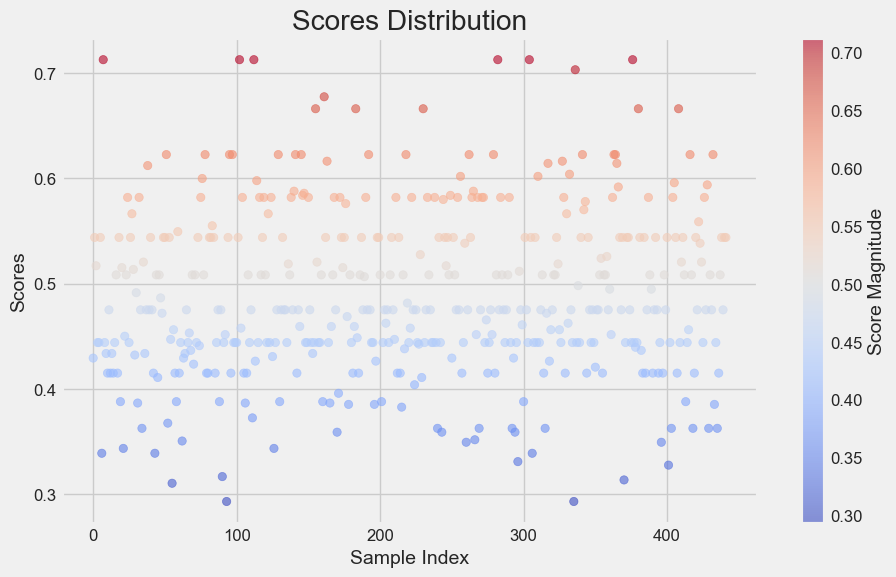

In [12]:
# Plot the scores with a gradient colormap
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_score)), decision_score, c=decision_score, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Score Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Scores')
plt.title('Scores Distribution')
plt.grid(True)
plt.show()

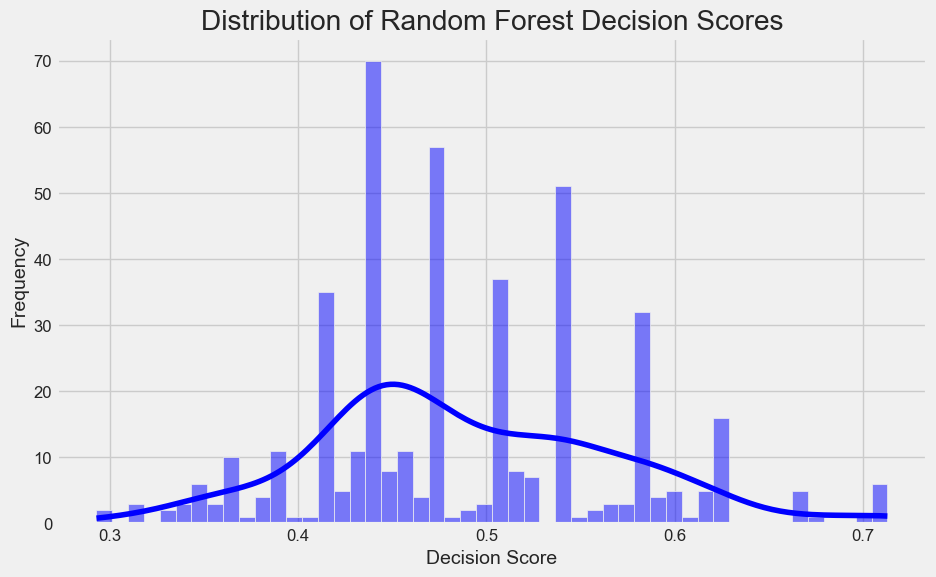

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(decision_score, bins=50, kde=True, color='blue')
plt.title('Distribution of Random Forest Decision Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Using Isolation Forest

In [14]:
print("Start training...")
start_time = time.time()
iForest=Isolation_forest(n_trees=20,subspace=256)
iForest.fit(data)
print(f'--- {round(time.time() - start_time, 3)} seconds ---')

Start training...
--- 3.344 seconds ---


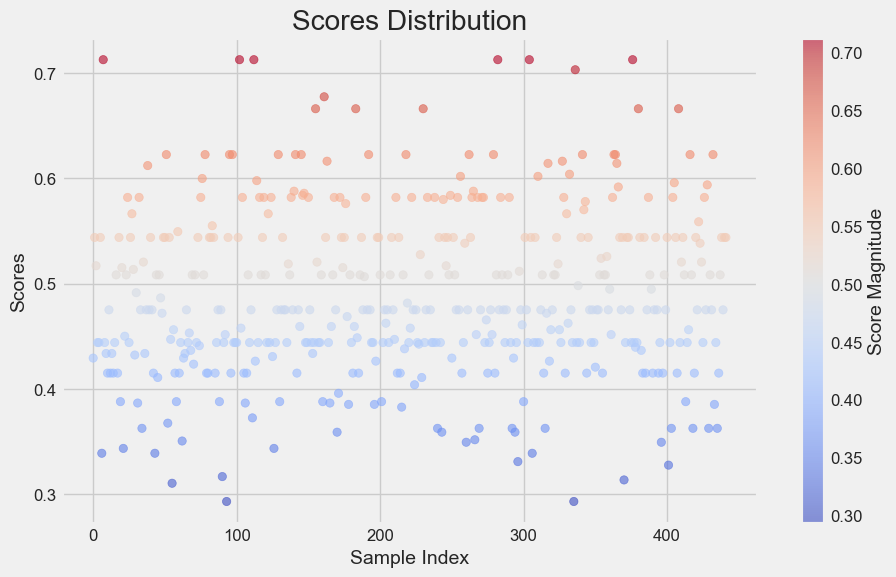

In [15]:
# Plot the scores with a gradient colormap
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_score)), decision_score, c=decision_score, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Score Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Scores')
plt.title('Scores Distribution')
plt.grid(True)
plt.show()

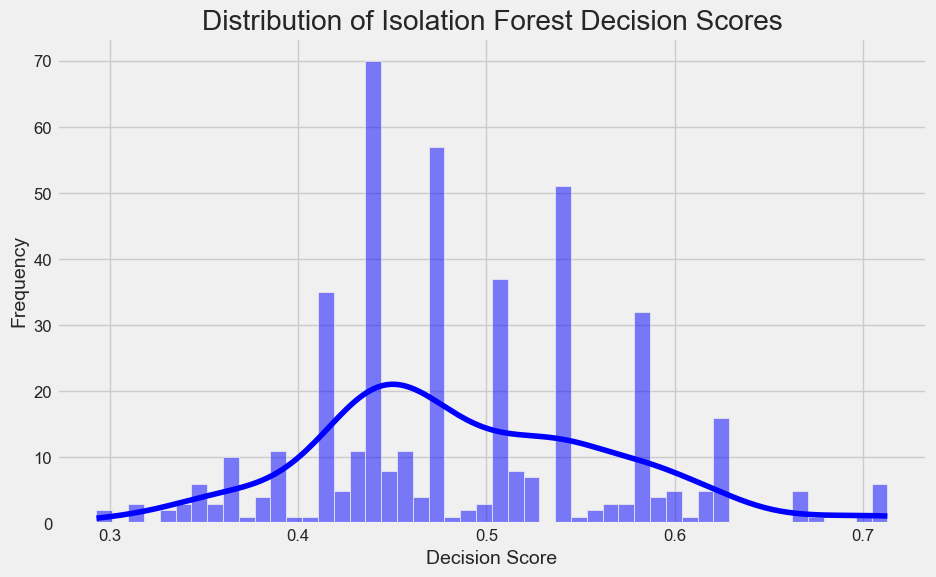

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(decision_score, bins=50, kde=True, color='blue')
plt.title('Distribution of Isolation Forest Decision Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Synthetic Regressor Data 

In [17]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
Nobjs = 2000
x, y = np.random.multivariate_normal(mean, cov, Nobjs).T
#Add manual outlier
x[0]=3.3
y[0]=3.3
X=np.array([x,y]).T
X = pd.DataFrame(X,columns=['feat1','feat2'])

Using Random Forest Regressor

In [18]:
print("Start training...")
start_time = time.time()
rForest=RandomForestRegressor(n_trees=20,subspace=256)
rForest.fit(X)
print(f'--- {round(time.time() - start_time, 3)} seconds ---')

Start training...
--- 75.809 seconds ---


In [19]:
decision_score=rForest.decisionScore(X)

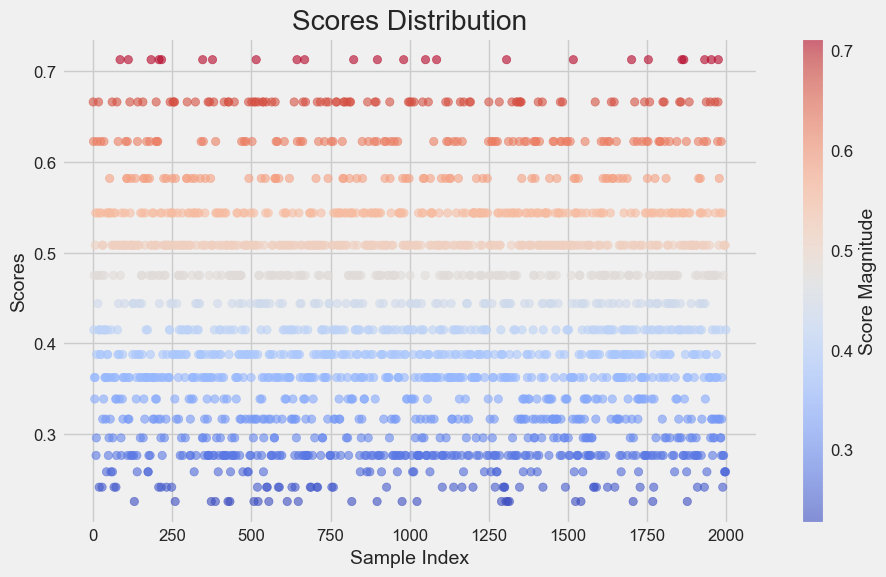

In [20]:
# Plot the scores with a gradient colormap
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_score)), decision_score, c=decision_score, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Score Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Scores')
plt.title('Scores Distribution')
plt.grid(True)
plt.show()

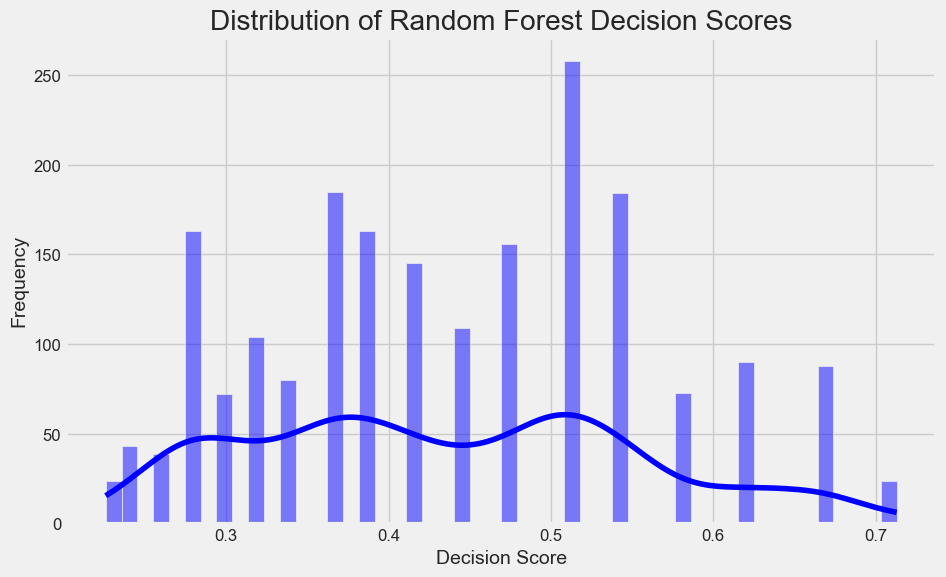

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(decision_score, bins=50, kde=True, color='blue')
plt.title('Distribution of Random Forest Decision Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

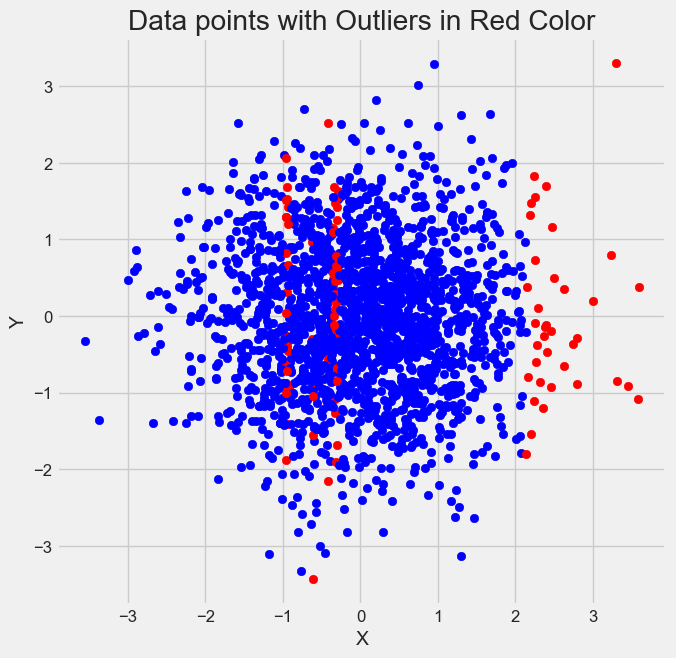

In [22]:
prediction=rForest.predict(X,0.03)
plt.figure(figsize=(7, 7))

# Plotting data points with specific colors based on prediction
for i in range(len(x)):
    color = 'r' if prediction[i] == -1 else 'b'
    plt.scatter(x[i], y[i], color=color)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data points with Outliers in Red Color')
plt.grid(True)
plt.show()

Using Isolation Forest

In [23]:
print("Start training...")
start_time = time.time()
isForest=Isolation_forest(n_trees=20,subspace=256)
isForest.fit(X)
print(f'--- {round(time.time() - start_time, 3)} seconds ---')

Start training...
--- 3.174 seconds ---


In [24]:
decision_score=isForest.decisionScore(X)

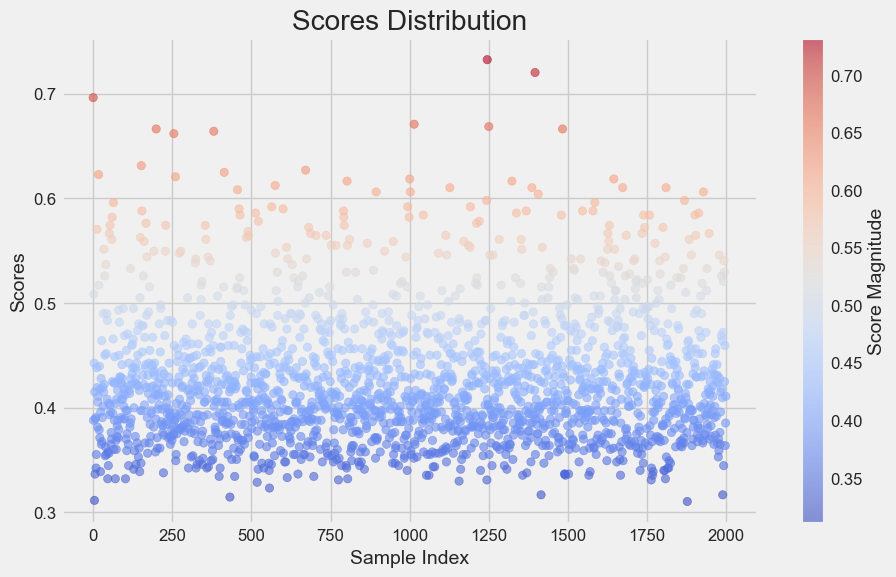

In [25]:
# Plot the scores with a gradient colormap
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_score)), decision_score, c=decision_score, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Score Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Scores')
plt.title('Scores Distribution')
plt.grid(True)
plt.show()

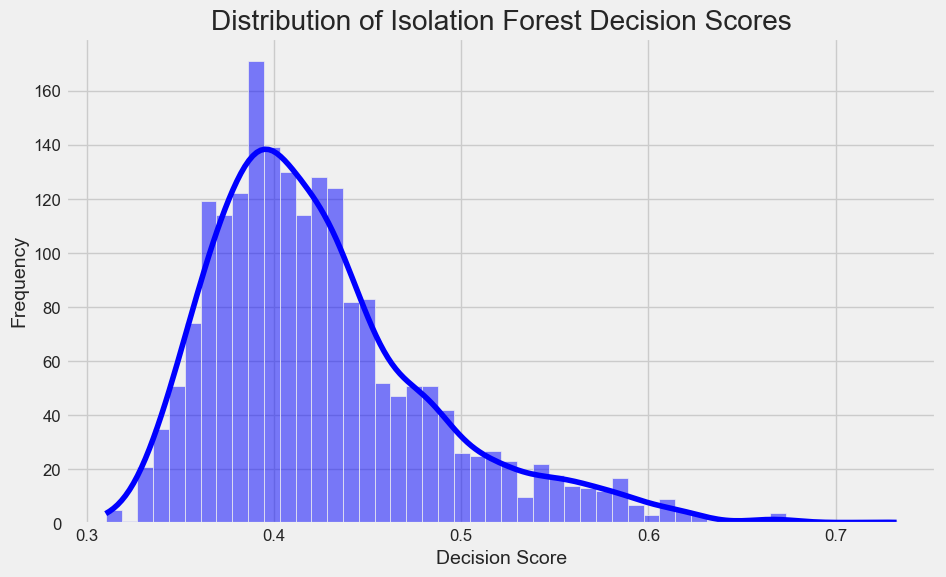

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(decision_score, bins=50, kde=True, color='blue')
plt.title('Distribution of Isolation Forest Decision Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

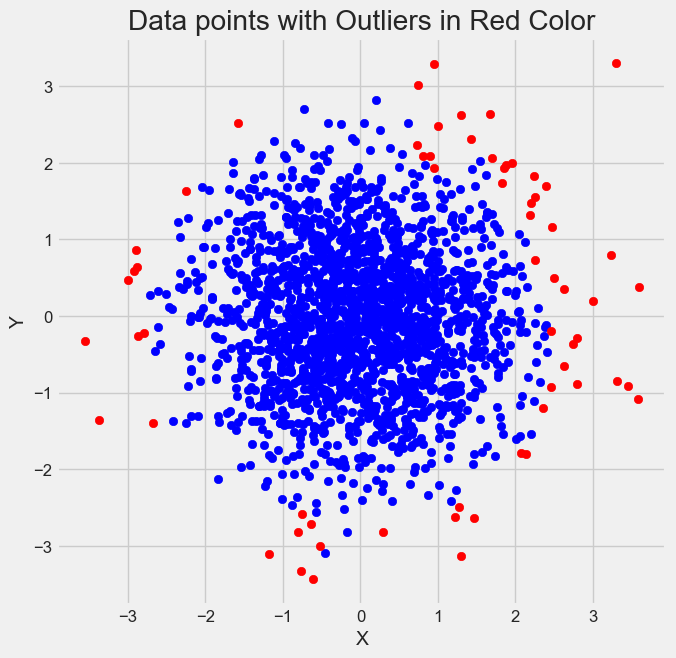

In [27]:
prediction=isForest.predict(X,0.03)
plt.figure(figsize=(7, 7))

# Plotting data points with specific colors based on prediction
for i in range(len(x)):
    color = 'r' if prediction[i] == -1 else 'b'
    plt.scatter(x[i], y[i], color=color)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data points with Outliers in Red Color')
plt.grid(True)
plt.show()

Classification dataset

In [28]:
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

# Convert data into a DataFrame
data = pd.DataFrame(X, columns=cancer.feature_names)

# Add target variable to the DataFrame
data['target']=y
# data.head(5)


In [29]:
print("Start training...")
start_time = time.time()
tree=RandomForestClassifier()
tree.fit(data)
print(f'--- {round(time.time() - start_time, 3)} seconds ---')

Start training...
--- 495.196 seconds ---


In [30]:
decision_score=tree.decisionScore(data)

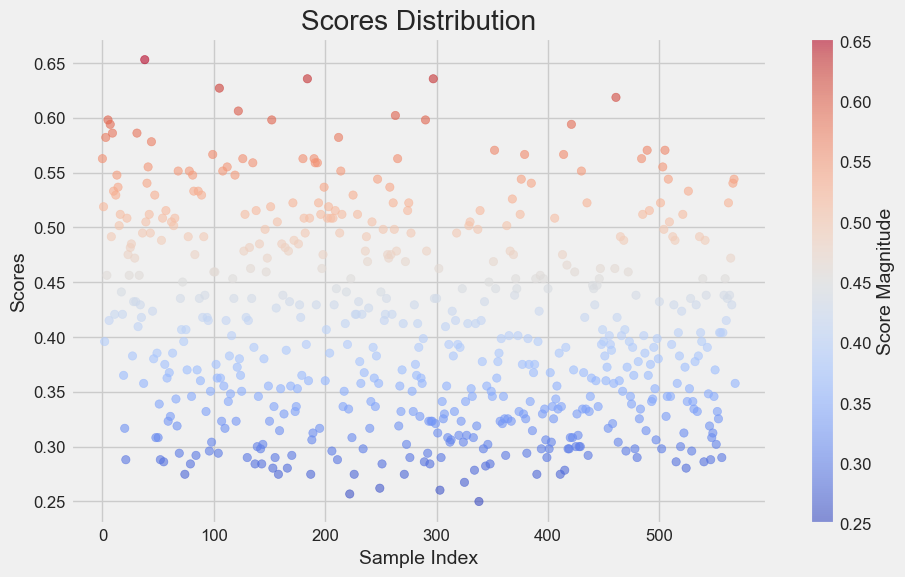

In [31]:
# Plot the scores with a gradient colormap
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_score)), decision_score, c=decision_score, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Score Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Scores')
plt.title('Scores Distribution')
plt.grid(True)
plt.show()

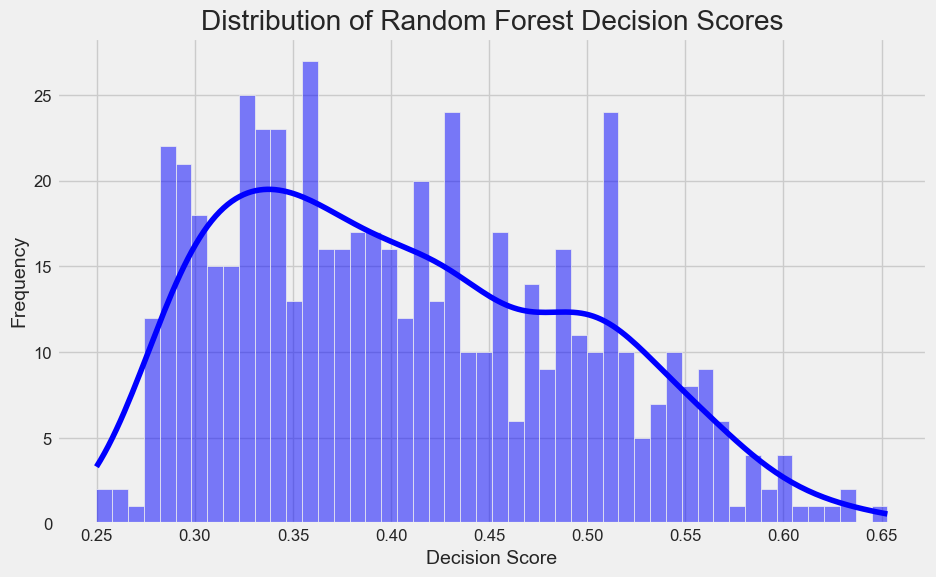

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(decision_score, bins=50, kde=True, color='blue')
plt.title('Distribution of Random Forest Decision Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Using Isolation Forest

In [33]:
print("Start training...")
start_time = time.time()
icForest=Isolation_forest(n_trees=20,subspace=256)
icForest.fit(data)
print(f'--- {round(time.time() - start_time, 3)} seconds ---')

Start training...
--- 3.88 seconds ---


In [34]:
decision_score=icForest.decisionScore(data)
prediction=icForest.predict(data,0.1)

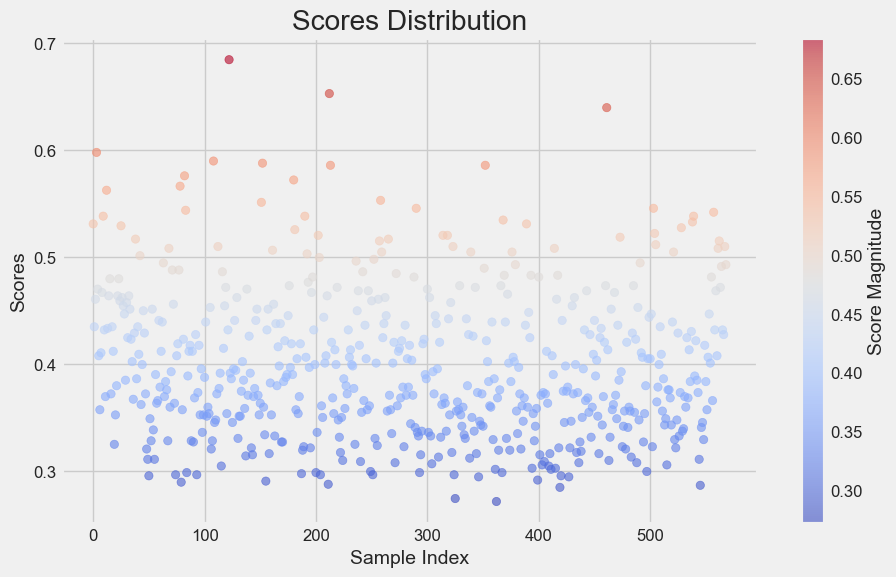

In [35]:
# Plot the scores with a gradient colormap
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_score)), decision_score, c=decision_score, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Score Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Scores')
plt.title('Scores Distribution')
plt.grid(True)
plt.show()

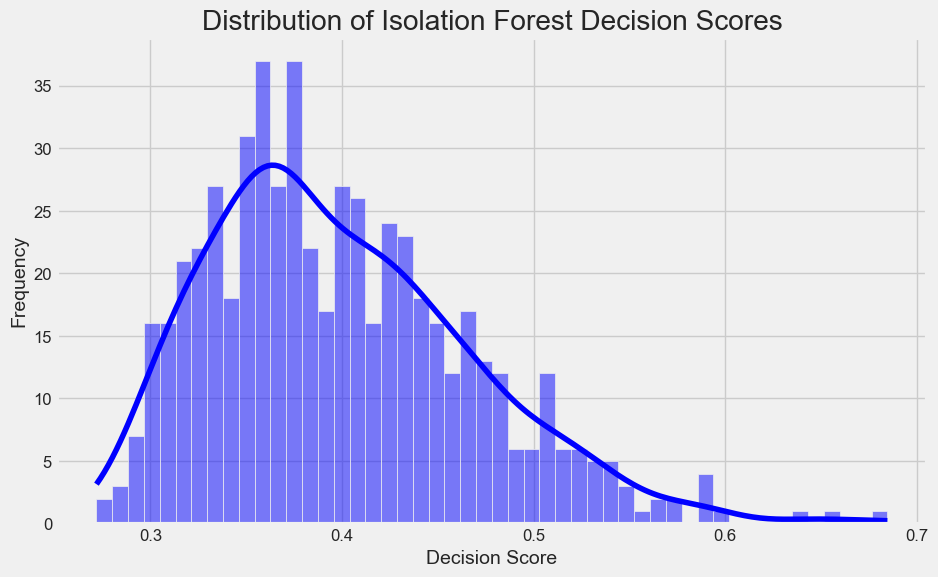

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(decision_score, bins=50, kde=True, color='blue')
plt.title('Distribution of Isolation Forest Decision Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Synthetic Data

In [37]:
# Number of samples
n_samples = 1000

# Number of features for regression
n_features = 1

# Number of classes
n_classes = 5

# Generate regression features
X, _ = make_regression(n_samples=n_samples, n_features=n_features, noise=0.1)

# Generate random class labels
y_classification = np.random.randint(0, n_classes, n_samples)

# Add some noise to the regression features
X_with_noise = X + np.random.normal(0, 0.1, size=X.shape)

# Concatenate the regression features and class labels
dataset = np.column_stack((X_with_noise, y_classification))

# Shuffle the dataset
np.random.shuffle(dataset)

# Split features and target
x = dataset[:, :-1]
y = dataset[:, -1].astype(int)

# Create DataFrame for regression features
regression_columns = [f"Feature_{i}" for i in range(n_features)]
regression_df = pd.DataFrame(x, columns=regression_columns)

# Create DataFrame for classification target
classification_df = pd.DataFrame({"Target": y})

# Merge the two DataFrames
X = pd.concat([regression_df, classification_df], axis=1)

Using Random Forest

In [38]:
print("Start training...")
start_time = time.time()
cfForest=RandomForestClassifier(n_trees=20,subspace=256)
cfForest.fit(X)
print(f'--- {round(time.time() - start_time, 3)} seconds ---')

Start training...
--- 154.872 seconds ---


In [39]:
decision_score=cfForest.decisionScore(X)

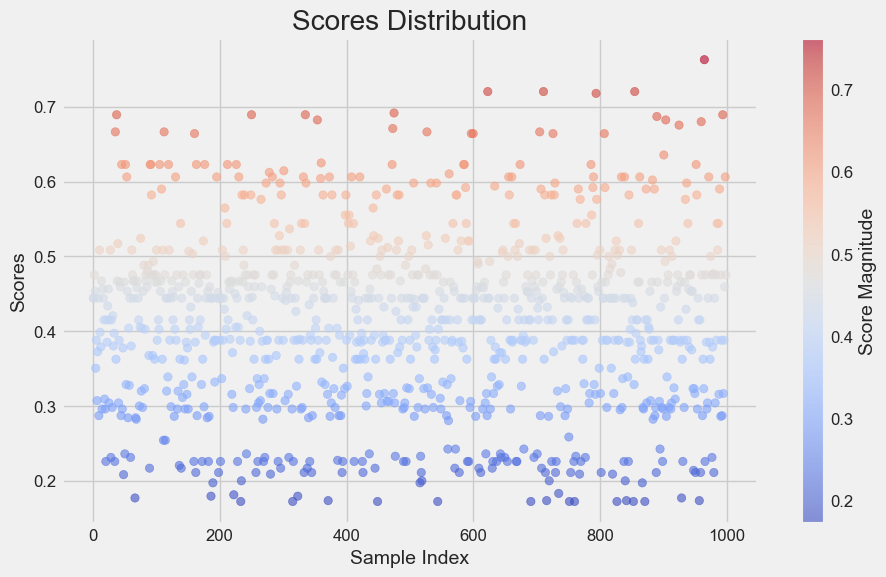

In [40]:
# Plot the scores with a gradient colormap
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_score)), decision_score, c=decision_score, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Score Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Scores')
plt.title('Scores Distribution')
plt.grid(True)
plt.show()

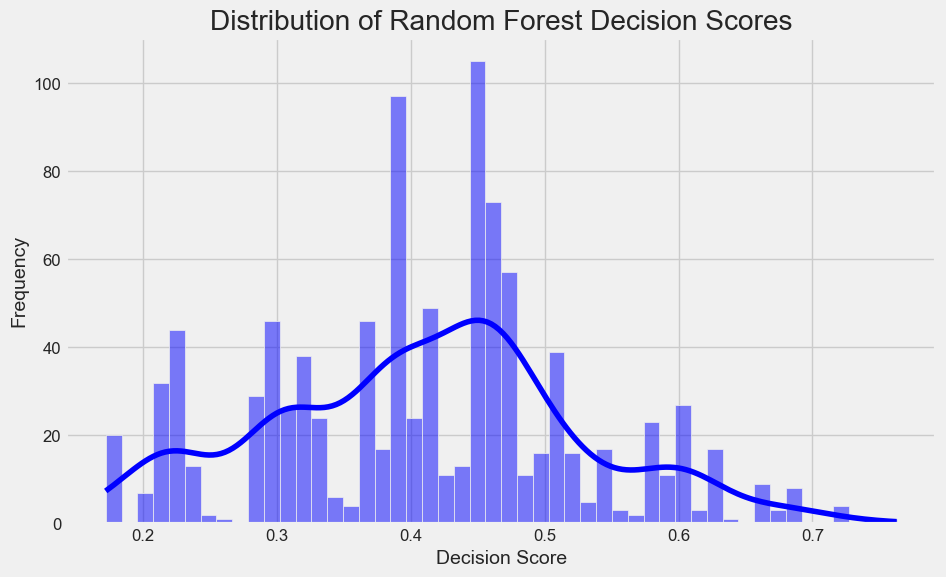

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(decision_score, bins=50, kde=True, color='blue')
plt.title('Distribution of Random Forest Decision Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

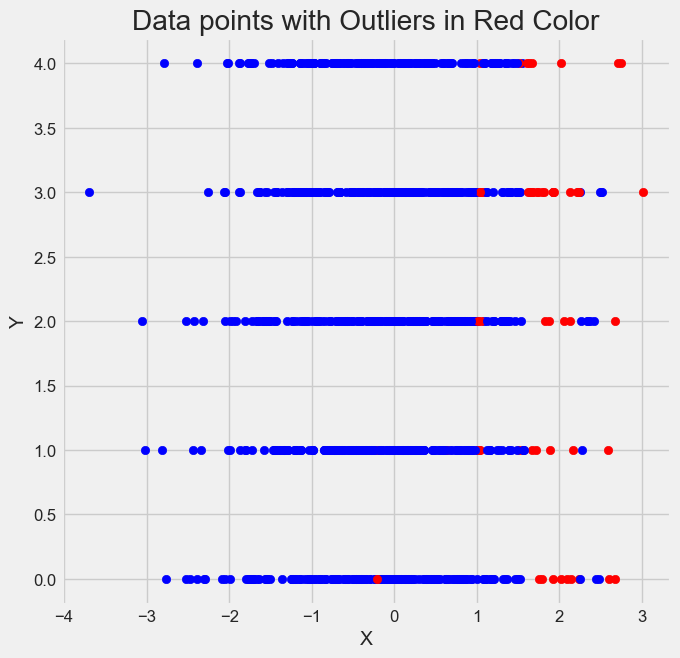

In [42]:
prediction=cfForest.predict(X,0.05)
plt.figure(figsize=(7, 7))

# Plotting data points with specific colors based on prediction
for i in range(len(x)):
    color = 'r' if prediction[i] == -1 else 'b'
    plt.scatter(x[i], y[i], color=color)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data points with Outliers in Red Color')
plt.grid(True)
plt.show()

Using Isolation Forest

In [43]:
print("Start training...")
start_time = time.time()
ifForest=Isolation_forest(n_trees=20,subspace=256)
ifForest.fit(X)
print(f'--- {round(time.time() - start_time, 3)} seconds ---')

Start training...
--- 5.446 seconds ---


In [44]:
decision_score=ifForest.decisionScore(X)

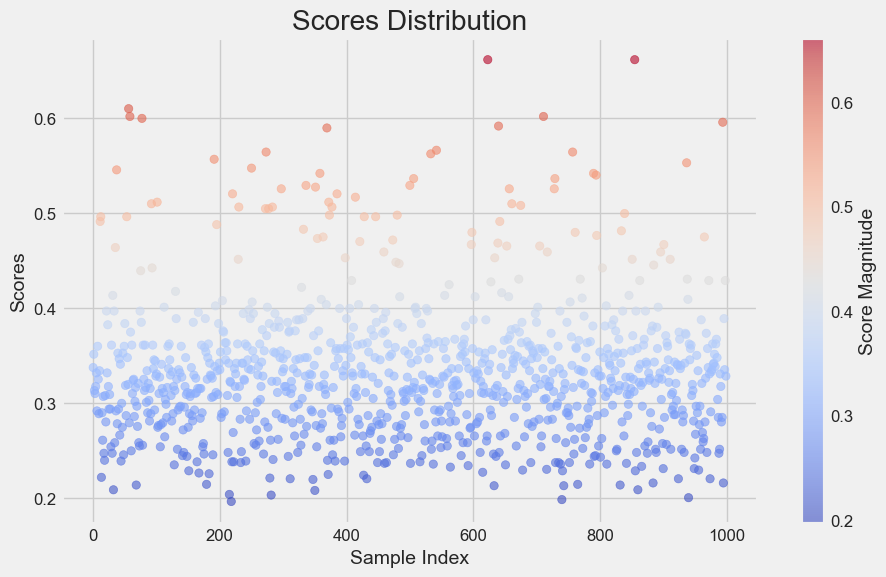

In [45]:
# Plot the scores with a gradient colormap
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_score)), decision_score, c=decision_score, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Score Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('Scores')
plt.title('Scores Distribution')
plt.grid(True)
plt.show()

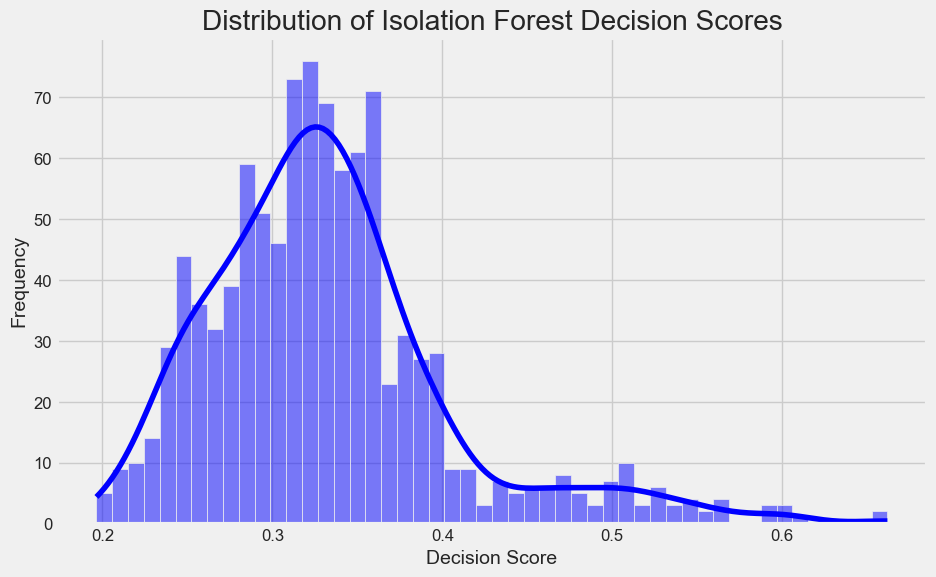

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(decision_score, bins=50, kde=True, color='blue')
plt.title('Distribution of Isolation Forest Decision Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

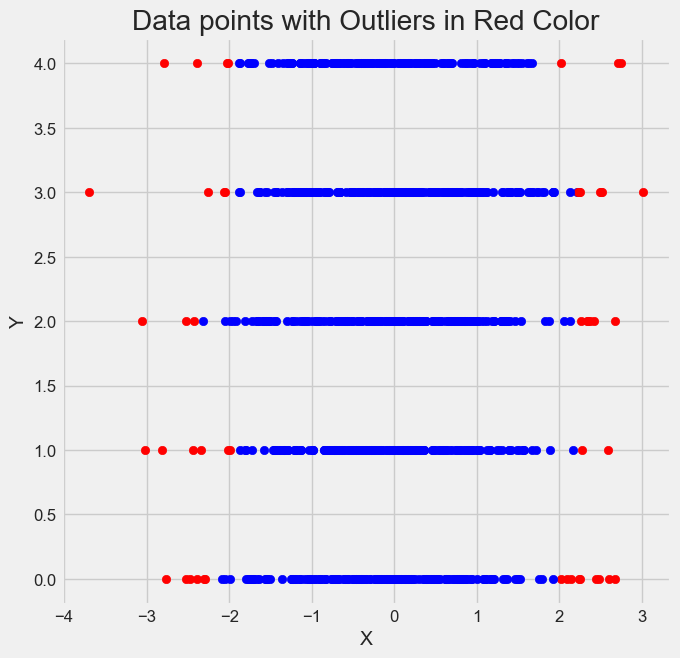

In [47]:
prediction=ifForest.predict(X,0.05)
plt.figure(figsize=(7, 7))

# Plotting data points with specific colors based on prediction
for i in range(len(x)):
    color = 'r' if prediction[i] == -1 else 'b'
    plt.scatter(x[i], y[i], color=color)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data points with Outliers in Red Color')
plt.grid(True)
plt.show()